In [1]:
import geometry
import scale_transform
import numpy as np
import matplotlib.pyplot as plt
import cv2
import json
import platonics
from segment_anything import sam_model_registry, SamPredictor
import sys
import segmentfunction
import utils
import math

done


In [2]:
# configuration
checkpointfilepath = r"C:\\Users\\aarus\\Downloads\\sam_vit_h_4b8939.pth"
num_slices = 5
transform_list = platonics.get_cube_transforms()

# test_1 = np.zeros((128, 128, 128))
# test_1[32:96, 48:80, 32:96] = 200
# test_2=np.ones((128,128,128))
# for i in range(128):
#     for j in range(128):
#         for k in range(128):
#             if ((i-64)**2+(j-64)**2+(k-64)**2)**0.5>50:
#                 test_2[i,j,k]=0
                
# plt.imshow(test_1[:,:,64])

In [27]:
def get_prompt_slices(image):
    slices_list = []
    for a, t in enumerate(transform_list):
        transformed_img = scale_transform.global_to_local(image, t)
        slice_transformed_img = transformed_img[:,:,transformed_img.shape[2]//2]
        cv2.imwrite(f'slices_for_prompting/slice_{a}.png', slice_transformed_img)

        slice_info = dict()
        slice_info['idx'] = transformed_img.shape[2]//2
        slice_info['transform'] = t
        slice_info['shape'] = transformed_img.shape
        slices_list.append(slice_info)    

    return slices_list

def get_line_segments(slices_list, pos_polylines_slices, neg_polylines_slices):
    pos_seg = []
    neg_seg = []

    for i, s in enumerate(slices_list):
        idx = s['idx']
        shape = s['shape']
        transform_curr = s['transform']
        print(i)

        for line in pos_polylines_slices[i]:
            global_line = []
            for point in line:
                scaled_point = scale_transform.scale_forward(point[:2] + [idx], shape)
                transformed_point = scale_transform.coord_to_index(scaled_point, transform_curr, shape)
                global_line.append(transformed_point)
            for j in range(len(global_line) - 1):
                pos_seg.append([global_line[j], global_line[j + 1]])

        for line in neg_polylines_slices[i]:
            if i == 1:
                print(line)
            global_line = []
            for point in line:
                scaled_point = scale_transform.scale_forward(point[:2] + [idx], shape)
                transformed_point = scale_transform.coord_to_index(scaled_point, transform_curr, shape)
                global_line.append(transformed_point)
            for j in range(len(global_line) - 1):
                neg_seg.append([global_line[j], global_line[j + 1]])
    
    return pos_seg, neg_seg

def get_intersections(matrix_shape, pos_seg, neg_seg, t, z):
    # calculate intersection points
    pos_intersects = []
    neg_intersects = []

    for p in pos_seg:
        point_1 = scale_transform.scale_backward(scale_transform.index_to_coord(p[0], t, matrix_shape), matrix_shape)
        point_2 = scale_transform.scale_backward(scale_transform.index_to_coord(p[1], t, matrix_shape), matrix_shape)

        intersection = scale_transform.get_intersection_point(point_1, point_2, z)
        if intersection:
            pos_intersects.append(intersection[:2])

    for n in neg_seg:
        point_1 = scale_transform.scale_backward(scale_transform.index_to_coord(n[0], t, matrix_shape), matrix_shape)
        point_2 = scale_transform.scale_backward(scale_transform.index_to_coord(n[1], t, matrix_shape), matrix_shape)

        intersection = scale_transform.get_intersection_point(point_1, point_2, z)
        if intersection:
            neg_intersects.append(intersection[:2])
    
    return pos_intersects, neg_intersects

def normalize (image):
    image = (image - np.min(image)) / (np.max(image) - np.min(image)) * 255
    image = image.astype(np.uint8)
    stacked = np.stack([image, image, image], axis=2)
    return stacked


In [7]:
# get prompt slices
folder = r"C:\Users\aarus\Downloads\slices_for_prompting\I1351301"

image = utils.load3dmatrix(folder)
print(image.shape)
cube = utils.padtocube(image)
print(cube.shape)

slices_list = get_prompt_slices(cube)

(256, 240, 208)
(256, 256, 256)


In [5]:
print(image.shape)

(256, 240, 208)


In [28]:
# given json with polylines
# parse
with open('data.json', 'r') as file:
    prompt_points = json.load(file)
pos_polylines_slices = []
neg_polylines_slices = []

for prompt in prompt_points:
    pos_polylines_slices.append(prompt['pos_polylines'])
    neg_polylines_slices.append(prompt['neg_polylines'])

# get pos, neg line segments
pos_seg, neg_seg = get_line_segments(slices_list, pos_polylines_slices, neg_polylines_slices)

0
1
[[238, 176, 0], [285, 217, 0], [276, 258, 0], [248, 272, 0], [207, 265, 0], [186, 245, 0], [183, 176, 0]]
2
3


In [29]:
print(pos_seg)

[[array([209., 245., 245.]), array([213., 239., 242.])], [array([213., 239., 242.]), array([211., 237., 232.])], [array([211., 237., 232.]), array([205., 242., 220.])], [array([205., 242., 220.]), array([197., 251., 216.])], [array([217., 231., 237.]), array([208., 244., 238.])], [array([208., 244., 238.]), array([204., 245., 224.])], [array([204., 245., 224.]), array([196., 252., 216.])], [array([228., 239., 198.]), array([223., 226., 215.])], [array([223., 226., 215.]), array([231., 234., 224.])], [array([231., 234., 224.]), array([238., 243., 225.])], [array([238., 243., 225.]), array([232., 240., 211.])], [array([232., 240., 211.]), array([230., 243., 195.])], [array([230., 243., 195.]), array([242., 248., 227.])], [array([244., 181., 243.]), array([225., 189., 242.])], [array([225., 189., 242.]), array([213., 198., 239.])], [array([213., 198., 239.]), array([211., 208., 232.])], [array([211., 208., 232.]), array([202., 223., 224.])], [array([202., 223., 224.]), array([195., 240., 

In [30]:
# initialize the model
sam_checkpoint = checkpointfilepath
model_type = "vit_h"
# device = "cuda"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
# sam.to(device=device)
predictor = SamPredictor(sam)

In [32]:
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


posintersects =  []
negintersects =  []
posintersects =  []
negintersects =  []
posintersects =  [(213.92445385421456, 247.9791774569689)]
negintersects =  [(253.81059205565688, 253.35070764794932), (191.82765025419502, 191.94401431441736), (207.98976183987762, 269.4179923954449), (237.78258388149763, 158.6024327301472)]
done2
[[213.92445385 247.97917746]
 [253.81059206 253.35070765]
 [191.82765025 191.94401431]
 [207.98976184 269.4179924 ]
 [237.78258388 158.60243273]]
[1 0 0 0 0]
done4
done5
(1, 442, 442)
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]


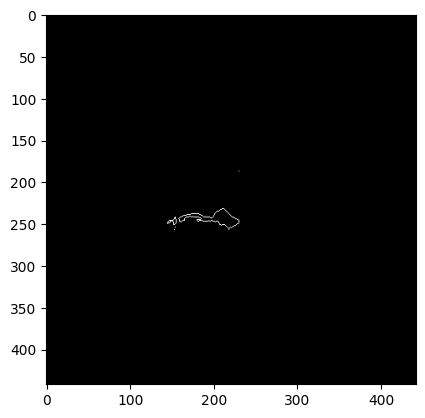

[[187, 230, 221], [232, 210, 221], [232, 211, 221], [232, 212, 221], [233, 208, 221], [233, 209, 221], [233, 210, 221], [233, 211, 221], [233, 212, 221], [233, 213, 221], [234, 207, 221], [234, 208, 221], [234, 209, 221], [234, 210, 221], [234, 211, 221], [234, 212, 221], [234, 213, 221], [234, 214, 221], [235, 204, 221], [235, 205, 221], [235, 206, 221], [235, 207, 221], [235, 208, 221], [235, 209, 221], [235, 210, 221], [235, 211, 221], [235, 212, 221], [235, 213, 221], [235, 214, 221], [235, 215, 221], [236, 203, 221], [236, 204, 221], [236, 205, 221], [236, 206, 221], [236, 207, 221], [236, 208, 221], [236, 209, 221], [236, 210, 221], [236, 211, 221], [236, 212, 221], [236, 213, 221], [236, 214, 221], [236, 215, 221], [236, 216, 221], [237, 202, 221], [237, 203, 221], [237, 204, 221], [237, 205, 221], [237, 206, 221], [237, 207, 221], [237, 208, 221], [237, 209, 221], [237, 210, 221], [237, 211, 221], [237, 212, 221], [237, 213, 221], [237, 214, 221], [237, 215, 221], [237, 216, 22

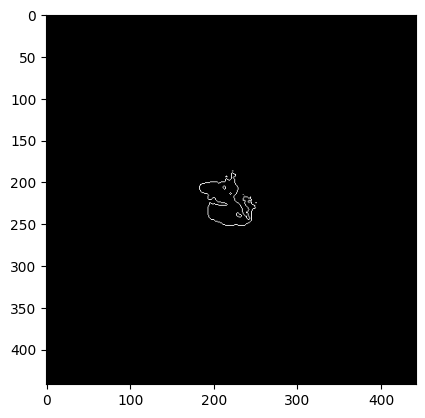

[[187, 222, 221], [187, 223, 221], [189, 222, 221], [190, 221, 221], [190, 222, 221], [190, 223, 221], [190, 224, 221], [191, 221, 221], [191, 222, 221], [191, 223, 221], [191, 224, 221], [191, 225, 221], [191, 226, 221], [192, 221, 221], [192, 222, 221], [192, 223, 221], [192, 224, 221], [192, 225, 221], [192, 226, 221], [193, 215, 221], [193, 221, 221], [193, 222, 221], [193, 223, 221], [193, 224, 221], [193, 225, 221], [193, 226, 221], [194, 214, 221], [194, 215, 221], [194, 216, 221], [194, 221, 221], [194, 222, 221], [194, 223, 221], [194, 224, 221], [194, 225, 221], [195, 221, 221], [195, 222, 221], [195, 223, 221], [196, 215, 221], [196, 221, 221], [196, 222, 221], [196, 223, 221], [196, 224, 221], [197, 214, 221], [197, 215, 221], [197, 216, 221], [197, 217, 221], [197, 220, 221], [197, 221, 221], [197, 222, 221], [197, 223, 221], [197, 224, 221], [197, 225, 221], [198, 214, 221], [198, 215, 221], [198, 216, 221], [198, 217, 221], [198, 218, 221], [198, 219, 221], [198, 220, 22

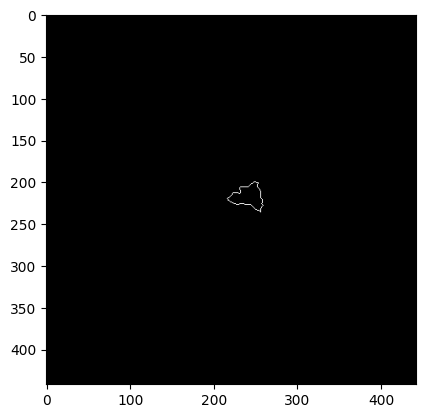

[[200, 248, 221], [200, 249, 221], [200, 250, 221], [201, 247, 221], [201, 248, 221], [201, 249, 221], [201, 250, 221], [201, 251, 221], [201, 252, 221], [201, 253, 221], [202, 245, 221], [202, 246, 221], [202, 247, 221], [202, 248, 221], [202, 249, 221], [202, 250, 221], [202, 251, 221], [202, 252, 221], [202, 253, 221], [203, 244, 221], [203, 245, 221], [203, 246, 221], [203, 247, 221], [203, 248, 221], [203, 249, 221], [203, 250, 221], [203, 251, 221], [203, 252, 221], [204, 243, 221], [204, 244, 221], [204, 245, 221], [204, 246, 221], [204, 247, 221], [204, 248, 221], [204, 249, 221], [204, 250, 221], [204, 251, 221], [204, 252, 221], [205, 242, 221], [205, 243, 221], [205, 244, 221], [205, 245, 221], [205, 246, 221], [205, 247, 221], [205, 248, 221], [205, 249, 221], [205, 250, 221], [205, 251, 221], [205, 252, 221], [206, 232, 221], [206, 233, 221], [206, 234, 221], [206, 235, 221], [206, 236, 221], [206, 237, 221], [206, 238, 221], [206, 239, 221], [206, 240, 221], [206, 241, 22

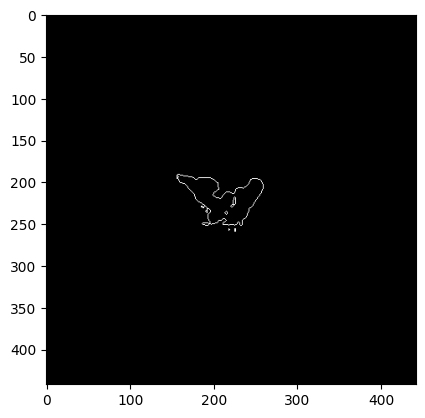

[[191, 157, 221], [191, 158, 221], [191, 159, 221], [192, 156, 221], [192, 157, 221], [192, 158, 221], [192, 159, 221], [192, 160, 221], [192, 161, 221], [192, 162, 221], [192, 163, 221], [193, 156, 221], [193, 157, 221], [193, 158, 221], [193, 159, 221], [193, 160, 221], [193, 161, 221], [193, 162, 221], [193, 163, 221], [193, 164, 221], [193, 165, 221], [193, 166, 221], [193, 167, 221], [193, 168, 221], [193, 169, 221], [194, 156, 221], [194, 158, 221], [194, 159, 221], [194, 160, 221], [194, 161, 221], [194, 162, 221], [194, 163, 221], [194, 164, 221], [194, 165, 221], [194, 166, 221], [194, 167, 221], [194, 168, 221], [194, 169, 221], [194, 170, 221], [194, 171, 221], [194, 172, 221], [194, 173, 221], [194, 174, 221], [195, 156, 221], [195, 157, 221], [195, 158, 221], [195, 159, 221], [195, 160, 221], [195, 161, 221], [195, 162, 221], [195, 163, 221], [195, 164, 221], [195, 165, 221], [195, 166, 221], [195, 167, 221], [195, 168, 221], [195, 169, 221], [195, 170, 221], [195, 171, 22

In [41]:
# BIG forloop
prompting_slices_dict = dict()
count = 0
allpoints = []

for t in transform_list:
    transformed_img = scale_transform.global_to_local(cube, t)
    matrix_shape = transformed_img.shape
    
    z_coord_list = np.linspace(0, transformed_img.shape[2], num_slices + 1, endpoint=False, dtype=int)[1:]  

    for z in z_coord_list:
        # get the slice of the rotated array
        slice_transformed_img = transformed_img[:,:,z]
        slice_shape = slice_transformed_img.shape
        
        pos_intersects, neg_intersects = get_intersections(matrix_shape, pos_seg, neg_seg, t, z)
        print("posintersects = ", pos_intersects)
        print("negintersects = ", neg_intersects)

        # maybe we dont need
        if len(pos_intersects) != 0:
            prompt = [pos_intersects, neg_intersects]
            points, boundary = segmentfunction.segment(predictor, normalize(slice_transformed_img), 0, prompt)
            pointstobeconverted = []
            for a in range(points.shape[0]):
                for b in range(points.shape[1]):
                    if points[a,b] == 1:
                        pointstobeconverted.append([a,b,z])
            print(pointstobeconverted)
            
            convertedpoints = [scale_transform.index_to_coord(p, t, matrix_shape) for p in pointstobeconverted]
            for i in convertedpoints:
                print(i)
                print(type(i))
                allpoints.append(i)

print(allpoints)



In [42]:
pcd = o3d.geometry.PointCloud()
n = np.zeros((len(allpoints), 3))
for i in range(len(allpoints)):
    n[i] = allpoints[i]
pcd.points = o3d.utility.Vector3dVector(n)
o3d.visualization.draw_geometries([pcd], window_name="Triangle Mesh")
